In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import pandas as pd

from functools import partial

import jax
from jax import vmap, jit

import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

key = random.PRNGKey(0)

In [32]:
# FROM LOCAL FILES
import os
import sys

from jax.scipy.linalg import cholesky

path_project_modules = os.path.join('modules')
sys.path.insert(1, path_project_modules)

from GP import predictGP, uncrt, sq_exp, cov_map

# Mixture model

In [33]:
# squared exponential kernel with diagonal noise term
def cov_matr(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    
    return cov_map(partial(sq_exp, l = length, v = var), X, Z) + \
                (noise*include_noise + jitter) * np.eye(X.shape[0], Z.shape[0])

In [34]:
kernel = cov_matr

In [35]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = np.linalg.inv(k_XX)
    
    K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    
    # generate random noise with GP variance at each test point
    sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1])
    mean = np.matmul(k_pX, np.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    
    return mean, mean + sigma_noise

Generate data from 2 GPs

In [6]:
t = np.linspace(-1, 1., 200)

In [7]:
key1, key2, key = random.split(key, 3)

K1 = 10
K2 = 10

In [8]:
x1 = random.uniform(key1, (K1, ), minval = -1, maxval = 0).sort()
x2 = random.uniform(key2, (K2, ), minval = 0, maxval = 1.).sort()

In [58]:
key, _ = random.split(key)

var1 = 1. 
length1 = .025 
noise1 = 0.
k1 = cov_matr(x1, x1, var1, length1, noise1, include_noise=False)

y1 = random.multivariate_normal(key, np.zeros(x1.shape), cov = k1, shape = ())
m1, ms1 = predict(key, x1, y1, t, var1, length1, noise1)

In [52]:
key, _ = random.split(key)

var2 = 1. 
length2 = .15 
noise2 = 0.
k2 = cov_matr(x2, x2, var2, length2, noise2, include_noise=False)

y2 = random.multivariate_normal(key, np.zeros(x2.shape), cov = k2, shape = ())
m2, ms2 = predict(key, x2, y2, t, var2, length2, noise2)

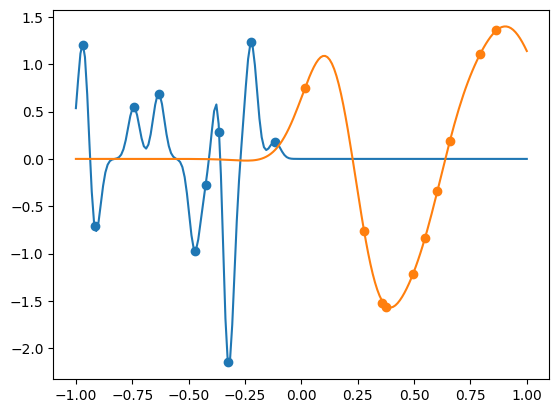

In [53]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.plot(t, m1)
plt.plot(t, m2)

In [54]:
m11, pc11 = predictGP(x1, y1, t, 
                      partial(sq_exp, l = length1, v = var1),
                      .0)

In [55]:
key, _ = random.split(key)
sm11 = uncrt(key, m11, pc11)

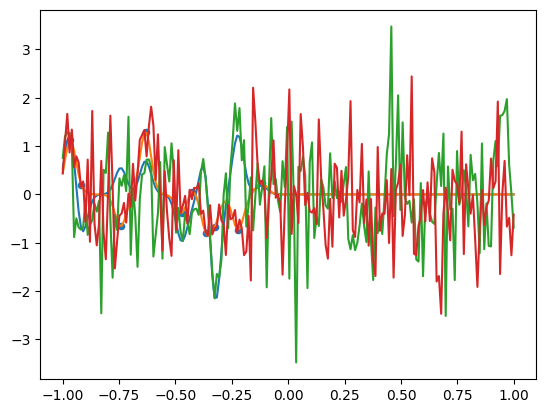

In [59]:
plt.plot(t, m11)
plt.plot(t, m1)
plt.plot(t, sm11)
plt.scatter(x1, y1, 20.)
plt.plot(t, ms1)

### Fit model

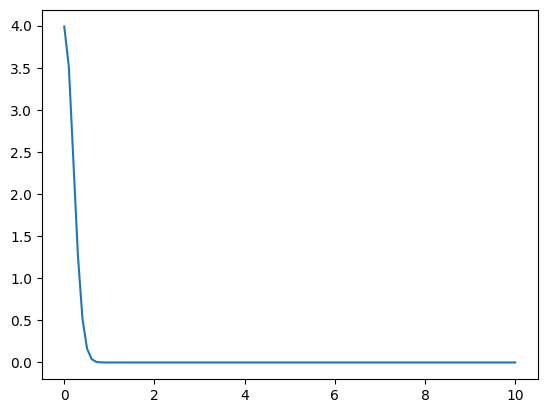

In [122]:
q = np.linspace(0, 10, 100)
plt.plot(q, np.exp(dist.HalfNormal(.2).log_prob(q)))

In [60]:
def model(N1, X, Y):
    # GPs on 2 intervals
    
    
    X1 = X[:N1]
    X2 = X[N1:]
    
    Y1 = Y[:N1]
    Y2 = Y[N1:]
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 20.0))
    length1 = numpyro.sample("kernel_length1", dist.HalfNormal(.2))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k2 = kernel(X2, X2, var2, length2, noise2)

    
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y1",
        dist.MultivariateNormal(loc=np.zeros(X1.shape[0]), covariance_matrix=k1),
        obs=Y1,
    )
    
    numpyro.sample(
        "Y2",
        dist.MultivariateNormal(loc=np.zeros(X2.shape[0]), covariance_matrix=k2),
        obs=Y2,
    )

In [61]:
N_mcmc = 1000
mcmc = MCMC(
        NUTS(model),
        num_warmup=1000,
        num_samples=N_mcmc,
        num_chains=1
    )

In [62]:
np.concatenate((x1, x2)).shape, np.concatenate((y1, y2)).shape

((20,), (20,))

In [63]:
key, key1 = random.split(key)
mcmc.run(key, 10, np.concatenate((x1, x2)), np.concatenate((y1, y2)))

sample: 100%|█| 2000/2000 [00:06<00:00, 325.23it/s, 63 steps of size 3.74e-02. a


In [64]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length1      0.10      0.11      0.05      0.00      0.25    215.00      1.00
  kernel_length2      0.16      0.02      0.16      0.13      0.18    229.12      1.00
   kernel_noise1      0.36      0.41      0.31      0.00      0.89    254.08      1.00
   kernel_noise2      0.00      0.00      0.00      0.00      0.00    406.22      1.00
     kernel_var1      0.34      0.48      0.14      0.00      0.82    242.96      1.00
     kernel_var2      1.64      1.72      1.20      0.25      3.01    325.50      1.00

Number of divergences: 0


In [65]:
length1, length2

(0.025, 0.15)

In [82]:
def model_predict(key, t, x1, y1, x2, y2, length1, var1, noise1, length2, var2, noise2):

    m1, k1 = predictGP(x1, y1,
              t, 
              partial(sq_exp, l = length1, v = var1), 
              noise1)

    m2, k2 = predictGP(x2, y2,
              t, 
              partial(sq_exp, l = length2, v = var2), 
              noise2)

    key1, key2 = random.split(key)
    
    dm1 = uncrt(key1, m1, k1)
    dm2 = uncrt(key2, m2, k2)
    
    return m1+m2, dm1+dm2

In [83]:
m, dm = model_predict(key, t, x1, y1, x2, y2, length1, var1, .1, length2, var2, .3)

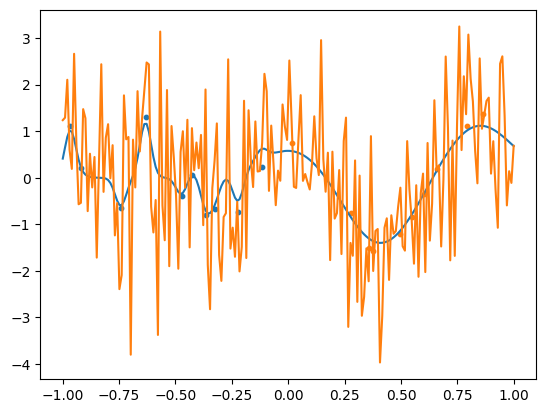

In [84]:
plt.plot(t, m)
plt.scatter(x1, y1, 10)
plt.scatter(x2, y2, 10)

plt.plot(t, dm)

In [85]:
vmap_model_predict = vmap(model_predict, in_axes=(0, None, None, None, None, None, 0, 0, 0, 0, 0, 0))

In [88]:
m, dm = vmap_model_predict(
    random.split(key, N_mcmc),
                   t, x1, y1, x2, y2,
                   mcmc.get_samples()['kernel_length1'], 
                   mcmc.get_samples()['kernel_var1'], 
                   mcmc.get_samples()['kernel_noise1'], 
                   mcmc.get_samples()['kernel_length2'], 
                   mcmc.get_samples()['kernel_var2'], 
                   mcmc.get_samples()['kernel_noise2'], 
                  )

In [96]:
mean_prediction = onp.mean(m, axis=0)

In [97]:
percentiles = onp.percentile(dm, [5.0, 95.0], axis=0)

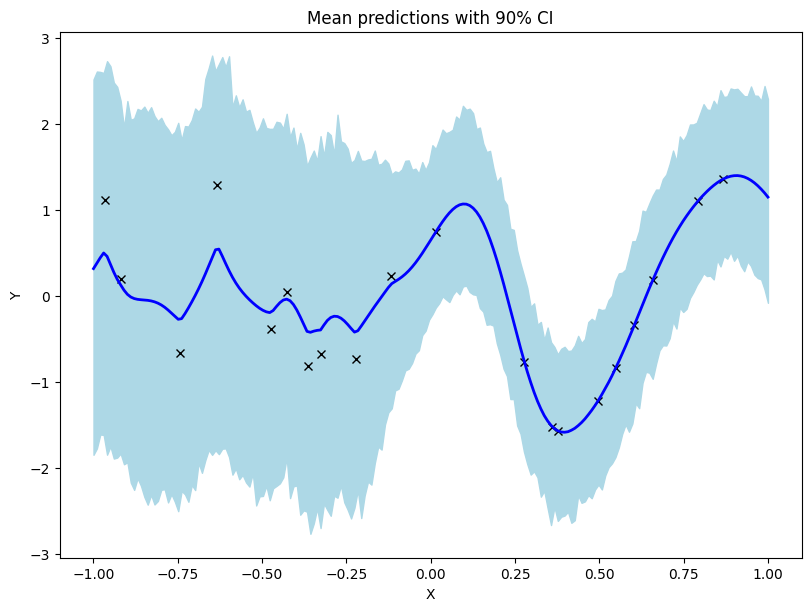

In [99]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(np.concatenate((x1,x2)), np.concatenate((y1,y2)), "kx")
# plot 90% confidence level of predictions
ax.fill_between(t, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(t, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");